This document details some of the code used to transform and explore the data extracted from the bike-share network. The python library "cycledata" has been developed to provide the necessary functions to import and transform this data. For more comprehensive documentation of the library refer to the "LibraryExamples" notebook.

In [2]:
import cycledata as cd
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.arima_process
import statsmodels.graphics.tsaplots
import seaborn as sns

# matplotlib.style.use('ggplot')
np.random.seed(sum(map(ord, "distributions")))
%matplotlib inline
    
def ts(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window,center=False).mean()
    rolstd = timeseries.rolling(window=window,center=False).std()


    #Plot rolling statistics:
    fig = plt.figure(figsize=(16,12))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='RollingMean')
    std = plt.plot(rolstd, color='black', label = 'RollingStd')

    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.ix[:,0], autolag='t-stat')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [2]:
# Import Full Years (non-seperated weeks)
FullYear = {}
FullYear = cd.Import('fullyear')
year15 = FullYear['2015'].copy()
year15.sort_values('s_date', inplace=True)
year15.set_index(year15.s_date, drop=True, inplace=True)
DF = year15[:'18-12-2015'].copy()
# Find nearest Sunday
j = 1
while(int(DF[-j:(len(DF) - j + 1)].index.dayofweek) != 6):
    j += 1
DF = DF[:(-j+1)]
# 4 week section of 2015 to be used for modelling an validation
recent = DF.last('4W')
# 10 weekends section of 2015 to be used for modelling and validation
recentWE = DF.last('5W')

Reading: 2012FullYear.csv
Reading: 2013FullYear.csv
Reading: 2014FullYear.csv
Reading: 2015FullYear.csv
Reading: 2016FullYear.csv


In [5]:
Jan15 = year15['1-2015'].copy()
Jul15 = year15['8-2015'].copy()
Jan15Speeds = cd.CalcSpeeds(Jan15)
Jul15Speeds = cd.CalcSpeeds(Jul15)

C:\Users\George Boss\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


2.2235578166448686

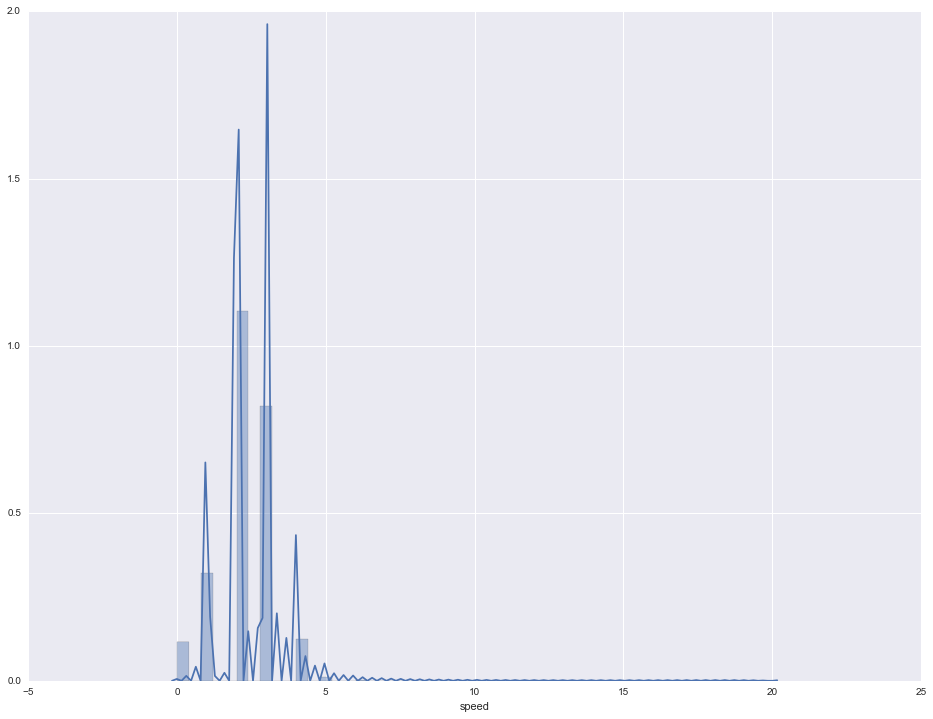

In [13]:
sns.set(rc={"figure.figsize": (16, 12)});
Jan15Speeds.dropna(inplace=True)
Jan15Speeds.speed = Jan15Speeds.speed.astype(int)
sns.distplot(Jan15Speeds.speed)
plt.savefig('Jan15Speeds.png', bbox_inches='tight', dpi=300)
Jan15.speed.mean() # 2.22m/s

C:\Users\George Boss\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


1.8948022532629145

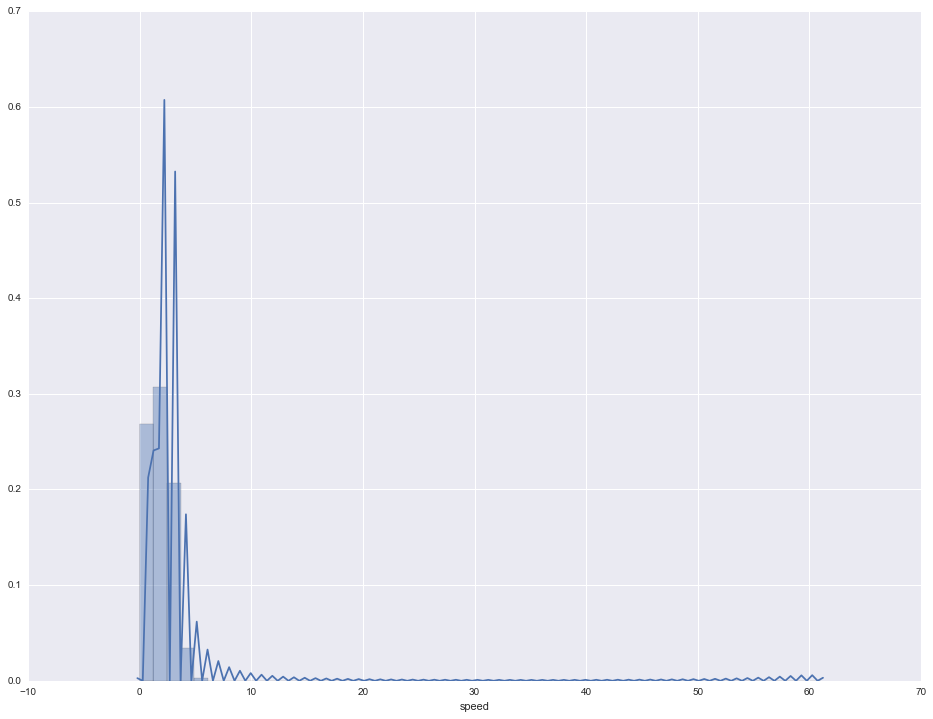

In [12]:
sns.set(rc={"figure.figsize": (16, 12)});
Jul15Speeds.dropna(inplace=True)
Jul15Speeds.speed = Jul15Speeds.speed.astype(int)
sns.distplot(Jul15Speeds.speed)
plt.savefig('Jul15Speeds.png', bbox_inches='tight', dpi=300)
Jul15.speed.mean() # 1.89m/s

C:\Users\George Boss\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


1078.8855268116424

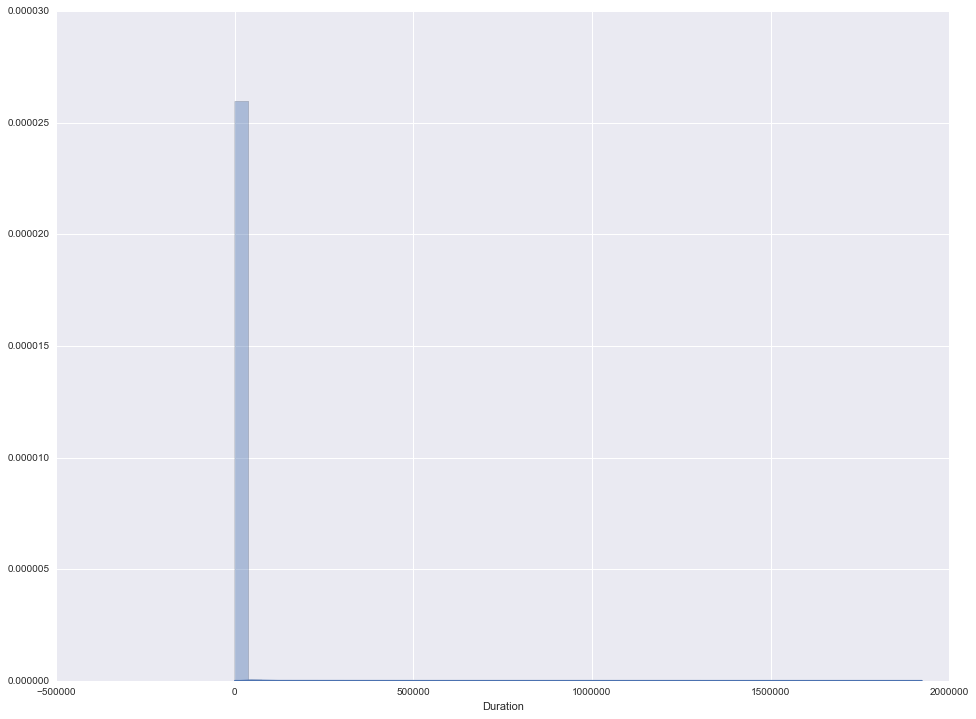

In [15]:
sns.distplot(Jan15.Duration)
Jan15.Duration.mean()

C:\Users\George Boss\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


1557.7411305752003

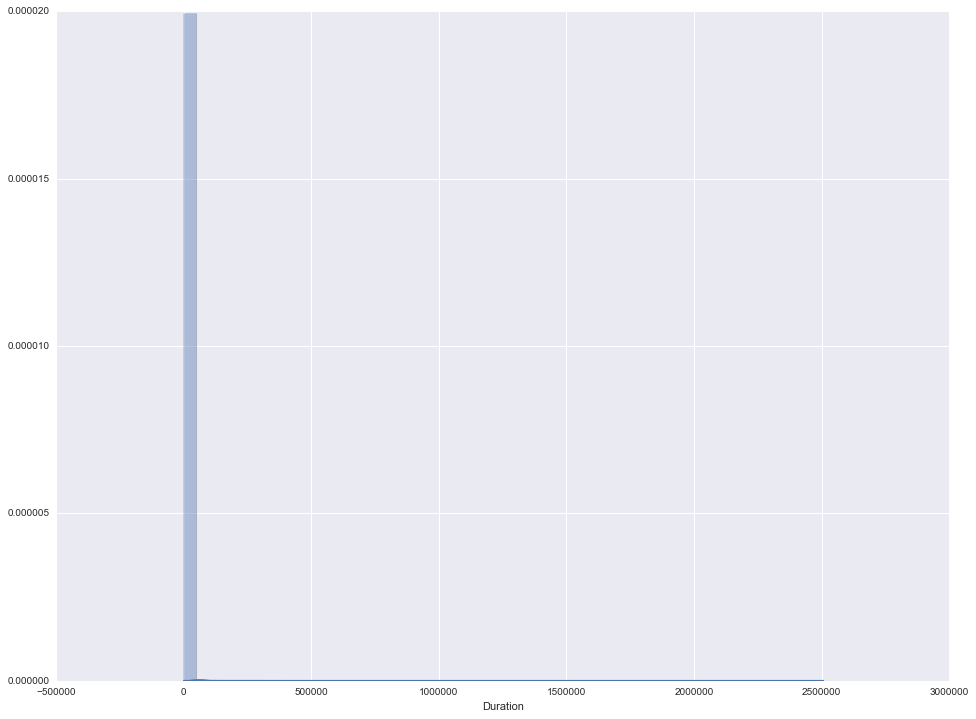

In [16]:
sns.distplot(Jul15.Duration)
Jul15.Duration.mean()

In [3]:
# Import Multi-Year Daily Usage
WDs, WEs = cd.Import('multi')
WDs.set_index('s_date', drop=True, inplace=True)

Reading: FullYearWDs.csv
Reading: FullYearWEs.csv


In [ ]:
# Plot FullSeries, Weekdays, Weekends
WDModel = cd.Model(recent, 14)
WDModel.PreProcess(separate=True)
WDModel.WD.reset_index(inplace=True, drop=True)
WDModel.WD = WDModel.WD[:(48*5*4)]
WDModel.WD.plot(figsize=(16,12), legend=False)

WEModel = cd.Model(recentWE, 191)
WEModel.PreProcess(separate=True)
WEModel.WE.reset_index(inplace=True, drop=True)
WEModel.WE = WEModel.WE[:48*10]
WEModel.WE.plot(figsize=(16,12), legend=False)

Model = cd.Model(recent, 14)
Model.PreProcess(separate=False)
Model.Full[:(48*7*4)].plot(figsize=(16,12), legend=False)

In [ ]:
ts(WDModel.WD, window=12)
ts(WEModel.WE, window=12)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(WEModel.WE, lags=48*2, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(WEModel.WE, lags=48*2, ax=ax2)
# plt.savefig('WEacf_pacf.png', bbox_inches='tight', dpi=300)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(WDModel.WD, lags=2*48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(WDModel.WD, lags=2*48, ax=ax2)
# plt.savefig('WDacf_pacf.png', bbox_inches='tight', dpi=300)

In [ ]:
WDdiff = (WDModel.WD - WDModel.WD.shift(1)).dropna()
ts(WDdiff, window=12)
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(WDdiff, lags=2*48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(WDdiff, lags=2*48, ax=ax2)
# plt.savefig('WDdiff_acf_pacf.png', bbox_inches='tight', dpi=300)

In [ ]:
WDdiff2 = (WDdiff - WDdiff.shift(1)).dropna()
ts(WDdiff2, window=12)
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(WDdiff2, lags=2*48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(WDdiff2, lags=2*48, ax=ax2)
# plt.savefig('WDdiff2_acf_pacf.png', bbox_inches='tight', dpi=300)

In [ ]:
WEseasdiff = (WEModel.WE - WEModel.WE.shift(18)).dropna()
ts(WEseasdiff, window=48)
WDseasdiff = (WDModel.WD - WDModel.WD.shift(48)).dropna()
ts(WDseasdiff, window=48)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(WDseasdiff, lags=2*48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(WDseasdiff, lags=2*48, ax=ax2)
# plt.savefig('WDseasDiffacf_pacf.png', bbox_inches='tight', dpi=300)

In [ ]:
# Plot distribution of journey duration
# recent.Duration = recent.Duration.astype(int)
colors = sns.set_palette("Reds")
sns.set(rc={"figure.figsize": (12, 8)})
row = recent.Duration <= 10800 # 3 hours
row2 = recent.Duration > 10800
durations = recent.loc[row, 'Duration'].copy() 
durations = durations.astype(int)
sns.distplot(durations.values)
excessive_durations = recent.loc[row2, :].copy()

In [ ]:
sns.kdeplot(recent.Duration)

In [ ]:
sns.distplot(recent.Duration, rug=True)

In [ ]:
# Creating High Resolution Figures
os.chdir(cd.wd)
sns.set_style({'axes.grid': True, 'axes.linewidth': 0.2})
# sns.set_style( "ticks", {"xtick.major.size": 24, "ytick.major.size": 16}) 
a=1 # Transparency
fig = plt.figure(figsize=(16,12))
# Add a subplot
ax = fig.add_subplot(111)

# Remove grid lines (dotted lines inside plot)
# ax.grid(False)
# Remove plot frame
#ax.set_frame_on(False)
# Pandas trick: remove weird dotted line on axis
#ax.lines[0].set_visible(False)

# Set x axis label on top of plot, set label text
ax.xaxis.set_label_position('bottom')
xlab = 'Date'
ax.set_xlabel(xlab, fontsize=16, alpha=a, ha='left')
# ax.xaxis.set_label_coords(0, 1.04)

# Set x axis label on top of plot, set label text
# ax.xaxis.set_label_position('left')
ylab = 'Daily Usage Count '
ax.set_ylabel(ylab, fontsize=16, alpha=a, ha='left')

# Set Title
ttl = "2012-2016 Daily Bike-Share Usage"
#fig.suptitle(ttl, fontsize=21)
plt.title(ttl, fontsize=22, y=1.03)

# Customize y tick labels
#yticks = [0,5000,10000,15000,20000,25000,35000,40000,45000,50000]
#ax.set_yticklabels(yticks, fontsize=16, alpha=a)
#ax.yaxis.set_tick_params(pad=12)  

# Customize x tick lables
#xticks = [5,10,20,50,80]
#ax.xaxis.set_ticks(xticks)
#ax.set_xticklabels(fontsize=16, alpha=a)
 

#DailyUsage['2014'].plot(figsize=(12,8), legend=False, ax=ax, title=ttl)
plt.plot(WDs['2012':'2015'])

# Save figure in png with tight bounding box
plt.savefig('test_fig.png', bbox_inches='tight', dpi=300)